# Introduction
This is a simple example to explore the expected evolution of He-Pb double dates.

Currently, I am going to explore a very simple scenario of a pluton that cooled a relatively long time ago, and was then exhumed. This model is also currently set up with the diffusion kinetics of Apatite, but that needs to be updated to use Zircon (which is how this work is actually done). 


In [2]:
#Import helpful functions
from matplotlib import pyplot as plt #For plotting
from matplotlib import cm #For colorbars
import numpy as np
#We want to import a local library too
import sys
import os

#If on google collab, install thermochronTools 
#!git clone https://github.com/johnsamstone/ThermochronTools.git 
# from ThermochronTools import Thermochronometer as tchron #Import a local library that helps integrate thermochron ages
# from ThermochronTools import  thermalHistory as tHist


#If working on local version, just add the path of the upper directory
%matplotlib notebook
sys.path.append(os.path.abspath('..')) #If working with local version
import Thermochronometer as tchron #Import a local library that helps integrate thermochron ages
import thermalHistory as tHist


# Defining a cooling history

The cooling history we are going to construct is as follows. A grain is crystalized at some time as a pluton cools. The pluton quickly obtains a geothermal gradient that is constant. At some point, exhumation begins causing progressively deeper grains to be exhumed. These grains are cooled at a constant rate that depends on the exhumation rate and the geothermal gradient. Cooling of a grain continues until it reaches the surface, and which point a small amount of time occurs while it is in transport, and then the grain is deposited. Despite burial, the grain maintains a constant temperature, which is that observed at Earth's surface.

# Parameters

 * $U$ [L/t]: the exhumation rate
 * $\frac{dT}{dz}$ [T/L]: A fixed geothermal gradients
 * $T_s$ [T]: A surface temperature
 * $Z_0$ [L]: the paleodepth or elevation from which a grain was eroded
 * $t_u$ [t]: the time exhumation starts
 * $t_{crys}$ [t]: the time that a grain was crystalized (e.g. U-Pb age)
 * $t_d$ [t]: the time a grain was deposit (e.g. stratigraphic age)
 * $\Delta t_l$ [t]: the time that a grain spent in transport (would probably start assuming this was 0)



In [3]:
#Lets define some simple functions to create a thermal history that can be used to predict a double data plot

def verticalExhumationThermHistory(dTdZ,T_s,U, t_crys,t_u,t_d,delt_l,t):
    '''
    '''
    
    T = np.zeros_like(t) #Preallocate temperature output to match time axis
    
    #If we haven't started to exhume grains, everything is at the surface...
    if t_d > t_u:
        T += T_s
    else:

        #The grain is cooling once uplift begins, and stops cooling when it hits the surface
        isCooling = (t < t_u) & (t >(t_d + delt_l)) #Boolean array for the duration of cooling
        T[isCooling] = T_s + U*(t[isCooling] - (t_d + delt_l))*dTdZ

        #The grain is sitting at its original depth if cooling has yet to begin
        Z_0 = U*(t_u - (t_d+delt_l))
        T[t>=t_u] = T_s + Z_0*dTdZ

        #The grain is at the surface once t (the current time) is greater than the age of deposition minus the transport time
        T[t<=(t_d + delt_l)] = T_s 
    
    return T
    

<IPython.core.display.Javascript object>


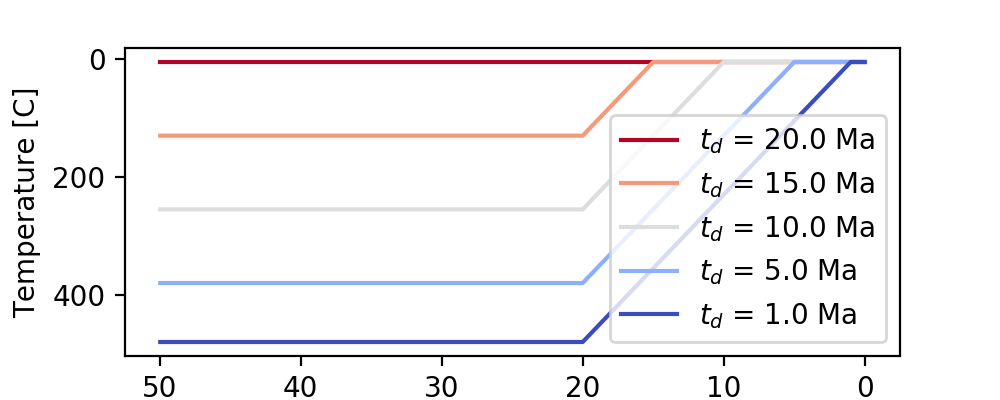

In [5]:
#Lets plot an example of that cooling history, first define some parameters
U = 1.0 / 1e3 #mm/yr -> m/yr
T_s = 5.0 #Degrees in celsius
dTdZ = 25.0 / 1000.0 #C/km -> C/m
t_crys = 50.0 *1e6 #Crystalization age
delt_l = 0 #Transport time of grain in years
t_ds = np.array([20,15, 10, 5, 1])*1e6 #Ages of deposition of grains in Myr -> yrs
t_u = 20.0 *1e6 #Age of initiation of exhumation in Myr -> years

dt_He = 50000.0 #Resolution of cooling history
#Create an axis for temperatures, sort it from young to old for giggles
t = np.arange(0,t_crys,dt_He)[::-1] 

cmap = cm.get_cmap('coolwarm_r')
colors = [cmap(i) for i in np.linspace(0,1,len(t_ds))] #Create a colormap for lines

f,axs = plt.subplots(1,1,figsize = (5,2),dpi = 200)

#Loop through the different depositional ages and make plots of those cooling histories
for i,t_d in enumerate(t_ds):
    T = verticalExhumationThermHistory(dTdZ,T_s,U, t_crys,t_u,t_d,delt_l,t)
    
    axs.plot(t/1e6,T,'-',color = colors[i],label = r'$t_d$ = {:.1f} Ma'.format(t_d/1e6))

axs.legend()
plt.xlabel('Time [Ma]')
plt.ylabel('Temperature [C]')
axs.invert_xaxis()
axs.invert_yaxis()

In [6]:
#Now lets actually simulate some thermochronometers evolving from these thermal histories
#Lets calculate this for more than just a few deposit ages
#Evenly spaced depositional ages from 25% more than start of uplift to modern
t_ds = np.linspace(t_u*1.25,0,20) 


#First we need to define some things inside the thermochronometer
#How big are grains?
Radius = 100.0 / 1e6  # Crystal radius in m
dx =1.0 / 1e6  # spacing of nodes in m
L =  np.arange(dx / 2.0, Radius, dx)

# Concentrations of parent nuclides
Conc238 = 1.0#8.0
Conc235 = (Conc238 / 137.0)
Conc232 = 1.0#147.0

#Specify uniform concentration profiles for the parent isotopes (e.g., not zones)
parentConcs = np.array([Conc238 * np.ones_like(L), 
                        Conc235 * np.ones_like(L), Conc232 * np.ones_like(L)])
daughterConcs = np.zeros_like(L)

#What is the temperature-dependent diffusivty we will use?
diffusivity = 'Farley'

#Create a model of a helium grain for each cooling history defined 
#by deposition at a different time
HeModels = [tchron.SphericalApatiteHeThermochronometer(Radius,
                    dx,parentConcs,daughterConcs,diffusivityParams=diffusivity)
                    for t_d in t_ds]

#Thermal histories are a special function that can interpolate a discrete
#set of time temperature points to predict diffusivity at any time
thermalHistories = [tHist.thermalHistory(-t,273.15+
                    verticalExhumationThermHistory(dTdZ,T_s,U, t_crys,t_u,t_d,delt_l,t))
                    for t_d in t_ds]

#Integrate these thermal histories
Ages_He = np.zeros(len(thermalHistories)) #
for i,HeModel in enumerate(HeModels):
    #Integrate this thermal history with a fixed timestemp
    HeModel.integrateThermalHistory(-t[0], 0,dt_He, thermalHistories[i].getTemp)
    Ages_He[i] = HeModel.calcAge(applyFt = True)

    


# Summarizing the data

One way to view changes in cooling ages upsection is by looking at the 'fractional helium loss' ($f$, Reiners et al., 2005, Saylor et al., 2012, Fosdick et al., 2015), defined as:

$$f = 100\% * \left(1 - \frac{Age_{He}}{Age_{U-Pb}}\right)$$

Values of 100% indicate that daughter Helium has not been lost since crystalization, and that the He age is reflecting the timing of crystalisation defined by the U-Pb age (here $t_{crys}$). Values close to zero indicate very recent and rapid cooling. Intermediate values reflect loss of He as a result of the grains thermal history

<IPython.core.display.Javascript object>


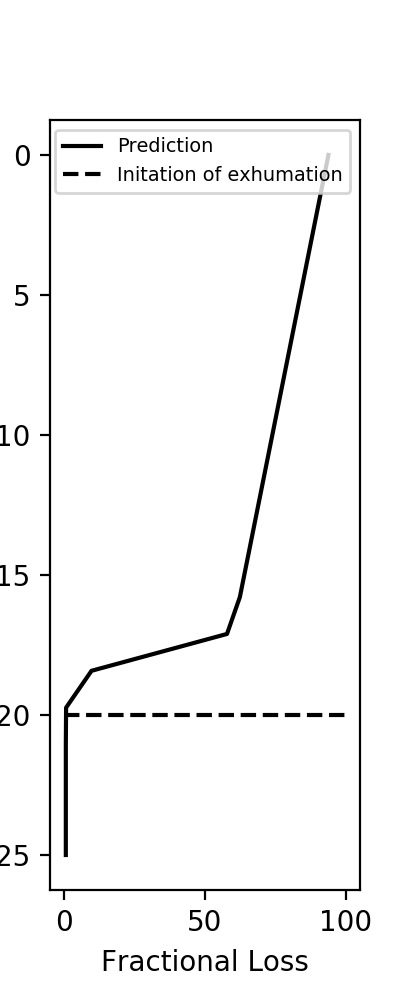

In [12]:

#Lets create a function to enable calculation of f
def fracLoss(Age_He,Age_UPb):
    return 100.0* (1.0 - Age_He/Age_UPb)

#Calculate F values for each point in the 'stratigraphic section' of modelled He ages
fs = np.zeros_like(t_ds)

for i in range(len(fs)):
    fs[i] = fracLoss(Ages_He[i],t_crys/1e6)
    
#Plot the results
f,axs = plt.subplots(1,1,figsize = (2,5),dpi= 200)
axs.plot(fs,t_ds/1e6,'-k',label = 'Prediction')
axs.invert_yaxis()
plt.xlabel('Fractional Loss')
plt.ylabel('Depositional Age')

#Plot some reference lines
axs.plot([0,100],[t_u/1e6,t_u/1e6],'--k',label = 'Initation of exhumation')

axs.legend(fontsize = 'x-small')
